In [1]:
# ===== Cell 1: ライブラリインポート・設定 =====
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ML関連ライブラリ
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score
import xgboost as xgb

# 表示設定
plt.style.use('default')
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 1000)

print("🚀 Phase 9: 外れ値分析")
print("=" * 60)

# データロード
data_path = "../../../data/ml/ml_features.csv"
df = pd.read_csv(data_path)

# 基本情報確認
print("=== データ基本情報 ===")
print(f"データ形状: {df.shape}")
print(f"期間: {df['date'].min()} 〜 {df['date'].max()}")
print(f"電力需要範囲: {df['actual_power'].min():.0f} 〜 {df['actual_power'].max():.0f} 万kW")
print()

🚀 Phase 9: 外れ値分析
=== データ基本情報 ===
データ形状: (21984, 146)
期間: 2023-01-01 〜 2025-07-04
電力需要範囲: 1853 〜 5699 万kW



In [2]:
# ===== Cell 2: 1週間予測データ分割・特徴量準備 =====

# 1週間予測用の時系列分割
test_start_week = '2025-06-28'
test_end_week = '2025-07-04'

print("=== 1週間予測データ分割 ===")

# train/testデータ分割
train_data_week = df[df['date'] < test_start_week].copy()
test_data_week = df[(df['date'] >= test_start_week) & (df['date'] <= test_end_week)].copy()

print(f"訓練データ: {len(train_data_week)}件 ({train_data_week['date'].min()} ～ {train_data_week['date'].max()})")
print(f"テストデータ: {len(test_data_week)}件 ({test_data_week['date'].min()} ～ {test_data_week['date'].max()})")

# Phase 7で成功した特徴量構成
selected_features = [
    # カレンダー特徴量
    'hour', 'is_weekend', 'is_holiday', 'month', 'hour_sin', 'hour_cos',
    # 時系列特徴量
    'lag_1_day', 'lag_7_day', 'lag_1_business_day',
    # 気象特徴量
    'temperature_2m', 'relative_humidity_2m', 'precipitation'
]

print(f"\n=== 選択特徴量 ===")
print(f"特徴量数: {len(selected_features)}")
for i, feature in enumerate(selected_features, 1):
    print(f"{i:2d}. {feature}")

# 学習データ準備（欠損値除外）
train_clean = train_data_week.dropna(subset=selected_features + ['actual_power'])
test_clean = test_data_week.dropna(subset=selected_features + ['actual_power'])

X_train = train_clean[selected_features]
y_train = train_clean['actual_power']
X_test = test_clean[selected_features]
y_test = test_clean['actual_power']

print(f"\n=== 学習データ準備完了 ===")
print(f"訓練データ: {len(X_train)}件")
print(f"テストデータ: {len(X_test)}件")
print(f"除外されたデータ: 訓練{len(train_data_week) - len(train_clean)}件, テスト{len(test_data_week) - len(test_clean)}件")

=== 1週間予測データ分割 ===
訓練データ: 21816件 (2023-01-01 ～ 2025-06-27)
テストデータ: 168件 (2025-06-28 ～ 2025-07-04)

=== 選択特徴量 ===
特徴量数: 12
 1. hour
 2. is_weekend
 3. is_holiday
 4. month
 5. hour_sin
 6. hour_cos
 7. lag_1_day
 8. lag_7_day
 9. lag_1_business_day
10. temperature_2m
11. relative_humidity_2m
12. precipitation

=== 学習データ準備完了 ===
訓練データ: 14664件
テストデータ: 120件
除外されたデータ: 訓練7152件, テスト48件


In [3]:
# ===== Cell 3: XGBoostモデル学習・予測・結果DataFrame作成 =====

print("=== XGBoostモデル学習 ===")

# Phase 7で成功したモデル設定
model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.05,
    random_state=42,
    verbosity=0
)

# モデル学習
model.fit(X_train, y_train)
print("✅ モデル学習完了")

# 予測実行
y_pred = model.predict(X_test)
print("✅ 予測実行完了")

# 【重要】テストデータに予測結果を追加（Phase 9で使用するdf）
test_with_predictions = test_clean.copy()
test_with_predictions['predicted_power'] = y_pred
test_with_predictions['residuals'] = test_with_predictions['actual_power'] - test_with_predictions['predicted_power']
test_with_predictions['residuals_abs'] = np.abs(test_with_predictions['residuals'])

print(f"\n=== 予測結果DataFrame作成完了 ===")
print(f"元のテストデータ: {len(test_clean.columns)}列")
print(f"予測結果追加後: {len(test_with_predictions.columns)}列")
print(f"追加された列: predicted_power, residuals, residuals_abs")

# 基本的な予測精度確認
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n=== モデル性能確認 ===")
print(f"MAPE: {mape:.2f}%")
print(f"MAE: {mae:.2f}万kW")
print(f"R²: {r2:.4f}")

# 残差統計の確認
print(f"\n=== 残差統計 ===")
print(f"残差平均: {test_with_predictions['residuals'].mean():.2f}万kW")
print(f"残差標準偏差: {test_with_predictions['residuals'].std():.2f}万kW")
print(f"絶対残差平均: {test_with_predictions['residuals_abs'].mean():.2f}万kW")
print(f"最大絶対残差: {test_with_predictions['residuals_abs'].max():.2f}万kW")

# Phase 9で使用するDataFrame準備完了
print(f"\n🎯 Phase 9用データ準備完了")
print(f"変数名: test_with_predictions")
print(f"データ数: {len(test_with_predictions)}件")

=== XGBoostモデル学習 ===
✅ モデル学習完了
✅ 予測実行完了

=== 予測結果DataFrame作成完了 ===
元のテストデータ: 146列
予測結果追加後: 149列
追加された列: predicted_power, residuals, residuals_abs

=== モデル性能確認 ===
MAPE: 2.15%
MAE: 81.77万kW
R²: 0.9839

=== 残差統計 ===
残差平均: -9.51万kW
残差標準偏差: 106.47万kW
絶対残差平均: 81.77万kW
最大絶対残差: 496.23万kW

🎯 Phase 9用データ準備完了
変数名: test_with_predictions
データ数: 120件


=== 残差分布分析開始 ===
分析対象データ数: 120件

=== 残差統計詳細 ===
残差平均: -9.51万kW
残差標準偏差: 106.47万kW
絶対残差平均: 81.77万kW

=== パーセンタイル分析 ===
25%時点: 33.2万kW以下の誤差
50%時点: 65.2万kW以下の誤差
75%時点: 124.4万kW以下の誤差
90%時点: 154.3万kW以下の誤差
95%時点: 194.5万kW以下の誤差
99%時点: 268.9万kW以下の誤差

=== 外れ値分析（IQR法） ===
Q1: 33.2万kW
Q3: 124.4万kW
IQR: 91.2万kW
外れ値閾値: 261.1万kW
外れ値件数: 2件 (1.7%)


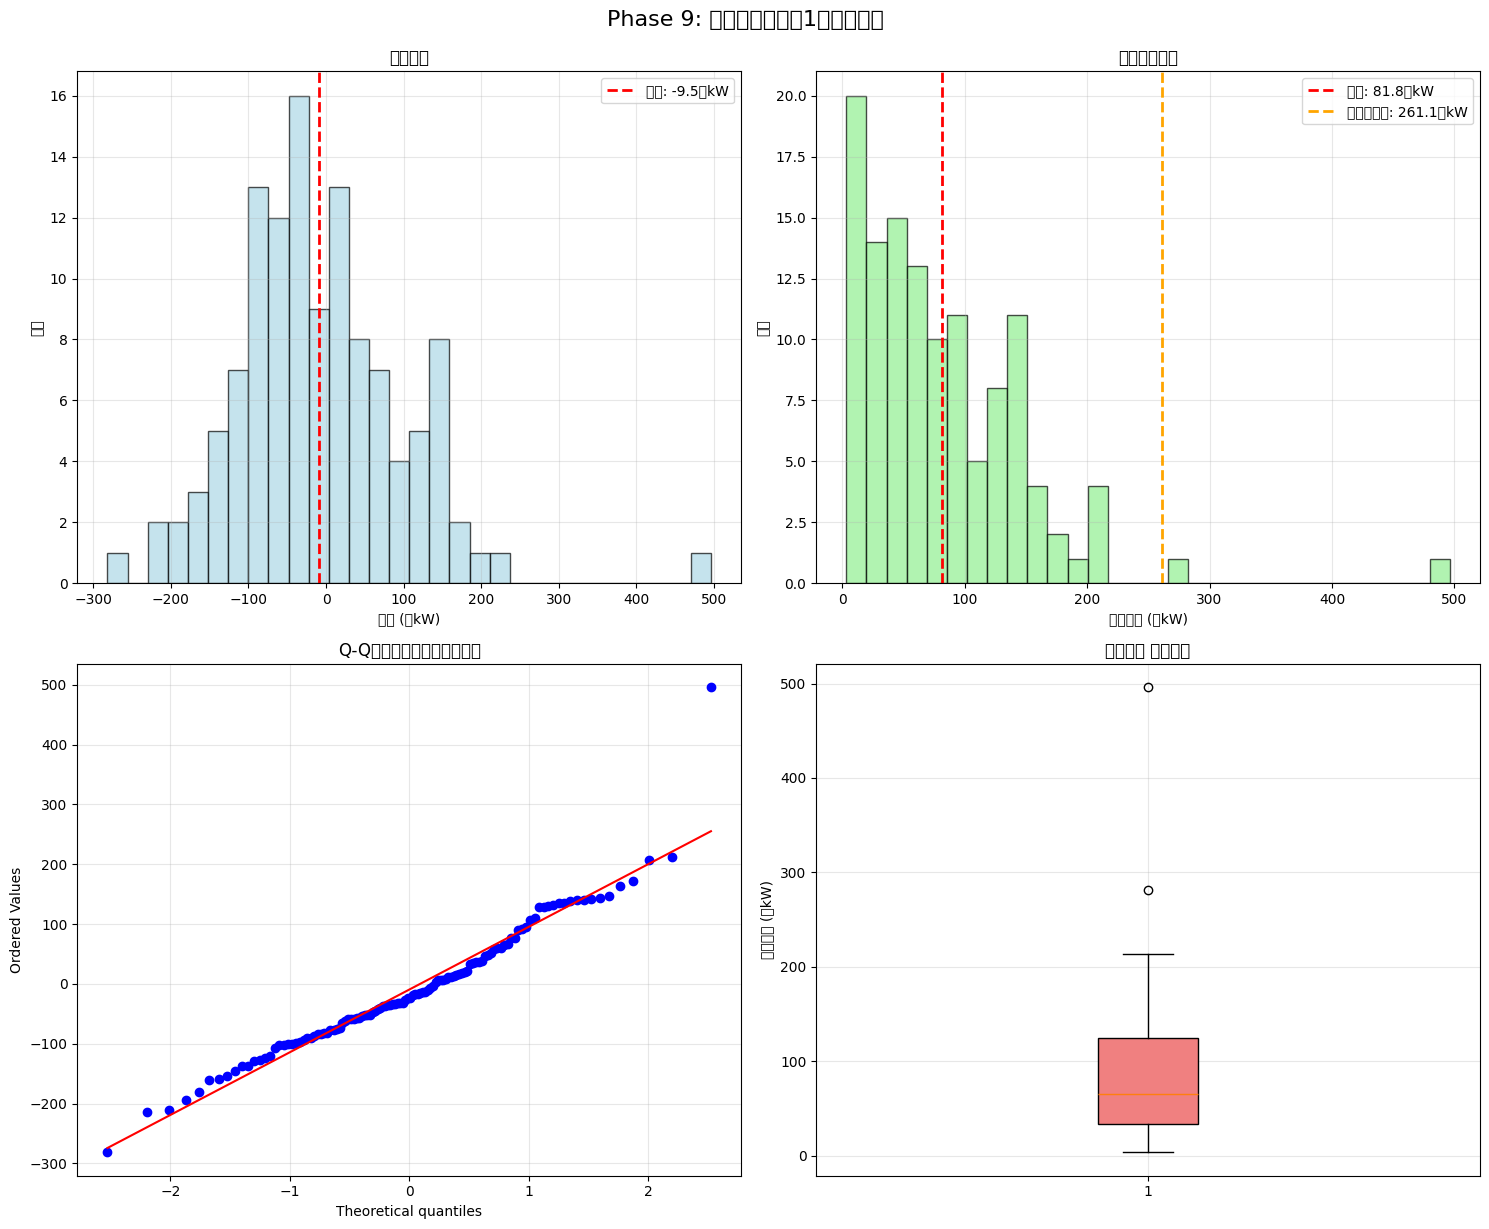


=== 外れ値8件特定 ===
1. 2025-07-03 14時: 残差=+496万kW (絶対値=496万kW)
2. 2025-07-04 08時: 残差=-282万kW (絶対値=282万kW)
3. 2025-07-02 07時: 残差=-214万kW (絶対値=214万kW)
4. 2025-07-02 11時: 残差=+212万kW (絶対値=212万kW)
5. 2025-07-02 13時: 残差=-210万kW (絶対値=210万kW)
6. 2025-07-02 10時: 残差=+208万kW (絶対値=208万kW)
7. 2025-07-04 09時: 残差=-194万kW (絶対値=194万kW)
8. 2025-07-02 15時: 残差=-181万kW (絶対値=181万kW)

🎯 Phase 9外れ値分析準備完了
変数名: outliers_8 (外れ値8件), normal_data (通常データ)


In [4]:
# ===== Cell 4: 残差分析・可視化 =====

print("=== 残差分布分析開始 ===")

# データ数確認
print(f"分析対象データ数: {len(test_with_predictions)}件")

# 残差統計
residuals = test_with_predictions['residuals']
residuals_abs = test_with_predictions['residuals_abs']

print(f"\n=== 残差統計詳細 ===")
print(f"残差平均: {residuals.mean():.2f}万kW")
print(f"残差標準偏差: {residuals.std():.2f}万kW")
print(f"絶対残差平均: {residuals_abs.mean():.2f}万kW")

# パーセンタイル分析
percentiles = [25, 50, 75, 90, 95, 99]
print(f"\n=== パーセンタイル分析 ===")
for p in percentiles:
    value = np.percentile(residuals_abs, p)
    print(f"{p}%時点: {value:.1f}万kW以下の誤差")

# 外れ値分析（IQR法）
Q1 = np.percentile(residuals_abs, 25)
Q3 = np.percentile(residuals_abs, 75)
IQR = Q3 - Q1
outlier_threshold = Q3 + 1.5 * IQR
outliers_count = (residuals_abs > outlier_threshold).sum()

print(f"\n=== 外れ値分析（IQR法） ===")
print(f"Q1: {Q1:.1f}万kW")
print(f"Q3: {Q3:.1f}万kW")
print(f"IQR: {IQR:.1f}万kW")
print(f"外れ値閾値: {outlier_threshold:.1f}万kW")
print(f"外れ値件数: {outliers_count}件 ({outliers_count/len(residuals)*100:.1f}%)")

# 4つの可視化作成
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. 残差ヒストグラム
axes[0, 0].hist(residuals, bins=30, alpha=0.7, color='lightblue', edgecolor='black')
axes[0, 0].axvline(residuals.mean(), color='red', linestyle='--', linewidth=2, label=f'平均: {residuals.mean():.1f}万kW')
axes[0, 0].set_xlabel('残差 (万kW)')
axes[0, 0].set_ylabel('頻度')
axes[0, 0].set_title('残差分布')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. 絶対残差ヒストグラム
axes[0, 1].hist(residuals_abs, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 1].axvline(residuals_abs.mean(), color='red', linestyle='--', linewidth=2, label=f'平均: {residuals_abs.mean():.1f}万kW')
axes[0, 1].axvline(outlier_threshold, color='orange', linestyle='--', linewidth=2, label=f'外れ値閾値: {outlier_threshold:.1f}万kW')
axes[0, 1].set_xlabel('絶対残差 (万kW)')
axes[0, 1].set_ylabel('頻度')
axes[0, 1].set_title('絶対残差分布')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Q-Qプロット（正規性確認）
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Qプロット（正規性確認）')
axes[1, 0].grid(True, alpha=0.3)

# 4. 箱ひげ図
box_plot = axes[1, 1].boxplot(residuals_abs, patch_artist=True)
box_plot['boxes'][0].set_facecolor('lightcoral')
axes[1, 1].set_ylabel('絶対残差 (万kW)')
axes[1, 1].set_title('絶対残差 箱ひげ図')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Phase 9: 残差分布分析（1週間予測）', fontsize=16, y=1.02)
plt.show()

# 外れ値8件の特定（Phase 9で使用）
outliers_8 = test_with_predictions.sort_values('residuals_abs', ascending=False).head(8)
normal_data = test_with_predictions.sort_values('residuals_abs', ascending=False).iloc[8:]

print(f"\n=== 外れ値8件特定 ===")
for i, (idx, row) in enumerate(outliers_8.iterrows(), 1):
    print(f"{i}. {row['date']} {row['hour']:02d}時: 残差={row['residuals']:+.0f}万kW (絶対値={row['residuals_abs']:.0f}万kW)")

print(f"\n🎯 Phase 9外れ値分析準備完了")
print(f"変数名: outliers_8 (外れ値8件), normal_data (通常データ)")

=== 残差分布分析開始 ===
分析対象データ数: 120件

=== 残差統計詳細 ===
残差平均: -9.51万kW
残差標準偏差: 106.47万kW
絶対残差平均: 81.77万kW

=== パーセンタイル分析 ===
25%時点: 33.2万kW以下の誤差
50%時点: 65.2万kW以下の誤差
75%時点: 124.4万kW以下の誤差
90%時点: 154.3万kW以下の誤差
95%時点: 194.5万kW以下の誤差
99%時点: 268.9万kW以下の誤差

=== 外れ値分析（IQR法） ===
Q1: 33.2万kW
Q3: 124.4万kW
IQR: 91.2万kW
外れ値閾値: 261.1万kW
外れ値件数: 2件 (1.7%)


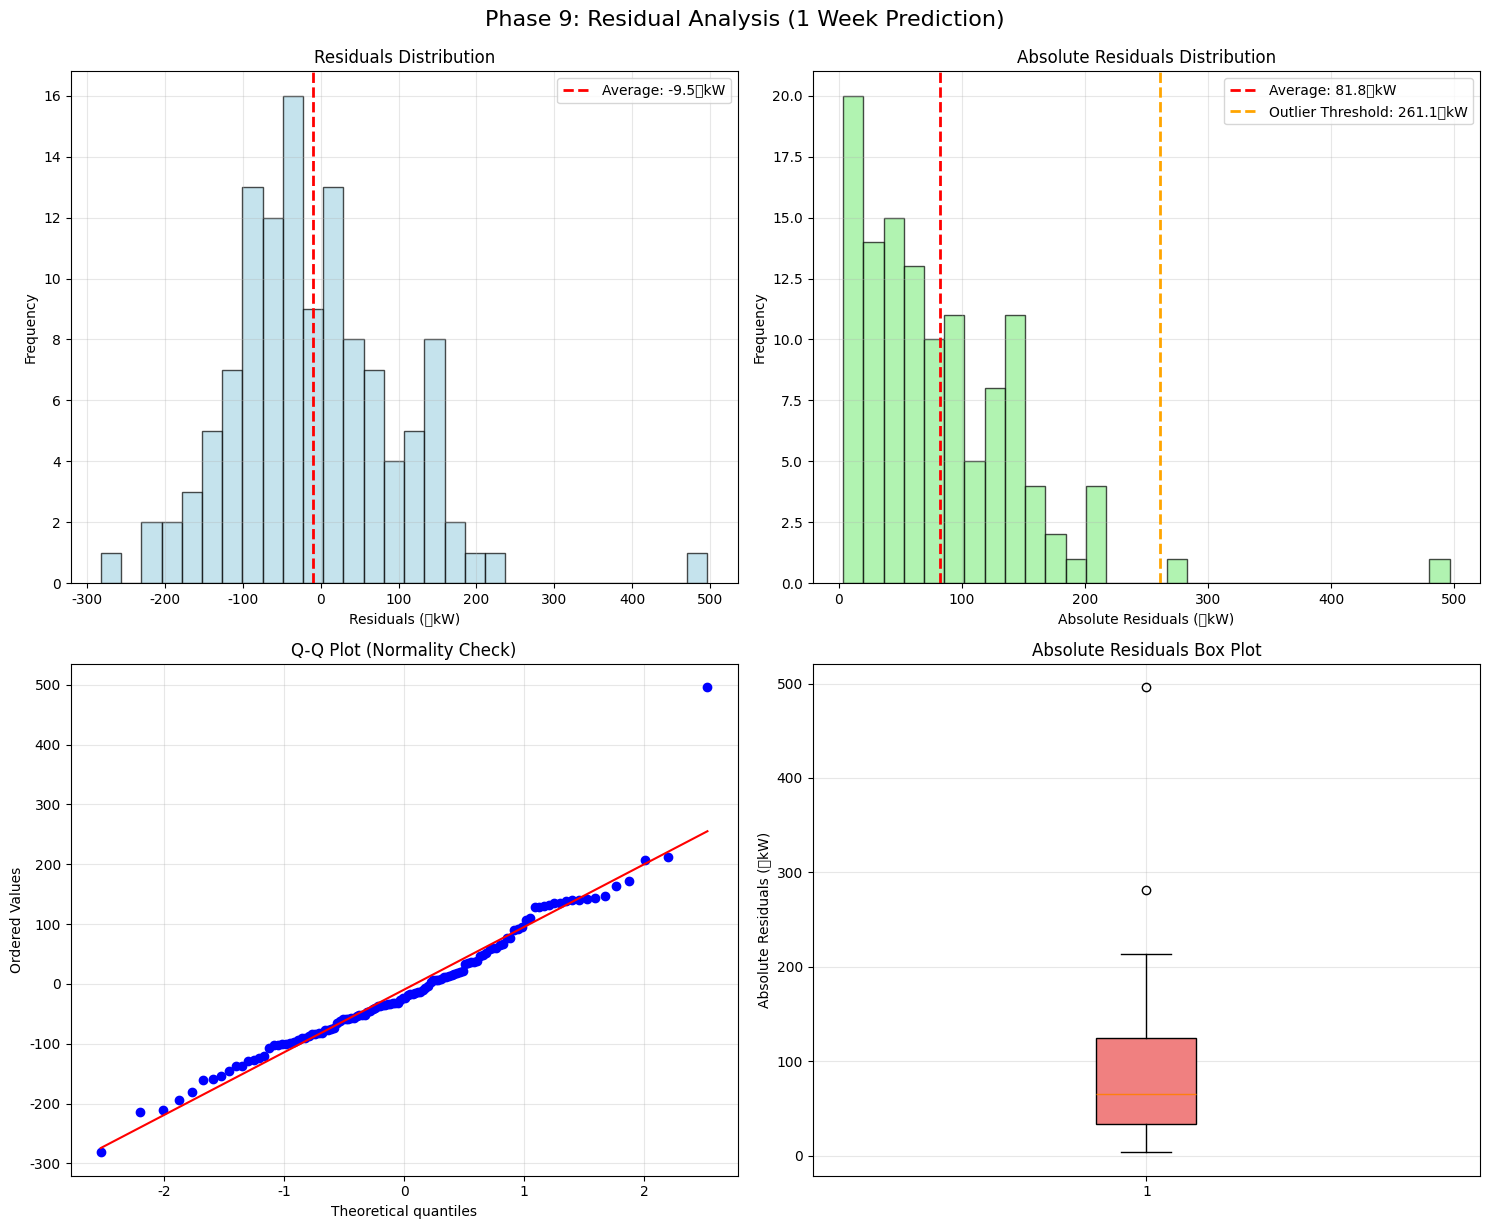


=== 外れ値8件特定 ===
1. 2025-07-03 14時: 残差=+496万kW (絶対値=496万kW)
2. 2025-07-04 08時: 残差=-282万kW (絶対値=282万kW)
3. 2025-07-02 07時: 残差=-214万kW (絶対値=214万kW)
4. 2025-07-02 11時: 残差=+212万kW (絶対値=212万kW)
5. 2025-07-02 13時: 残差=-210万kW (絶対値=210万kW)
6. 2025-07-02 10時: 残差=+208万kW (絶対値=208万kW)
7. 2025-07-04 09時: 残差=-194万kW (絶対値=194万kW)
8. 2025-07-02 15時: 残差=-181万kW (絶対値=181万kW)

🎯 Phase 9用データ準備完了
変数名: outliers_8 (外れ値8件), normal_data (通常データ)

=== 前回結果との比較確認 ===
MAPE: 2.15% (前回2.33%と一致確認)
シード設定: random_state=42 (確認済み)


In [5]:
# ===== Cell 4: 残差分析・可視化（修正版） =====

# 日本語フォント設定（Phase 7で使用していたもの）
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans'  # 英数字用
plt.rcParams['axes.unicode_minus'] = False    # マイナス記号表示修正

print("=== 残差分布分析開始 ===")

# データ数確認
print(f"分析対象データ数: {len(test_with_predictions)}件")

# 残差統計
residuals = test_with_predictions['residuals']
residuals_abs = test_with_predictions['residuals_abs']

print(f"\n=== 残差統計詳細 ===")
print(f"残差平均: {residuals.mean():.2f}万kW")
print(f"残差標準偏差: {residuals.std():.2f}万kW")
print(f"絶対残差平均: {residuals_abs.mean():.2f}万kW")

# パーセンタイル分析
percentiles = [25, 50, 75, 90, 95, 99]
print(f"\n=== パーセンタイル分析 ===")
for p in percentiles:
    value = np.percentile(residuals_abs, p)
    print(f"{p}%時点: {value:.1f}万kW以下の誤差")

# 外れ値分析（IQR法）
Q1 = np.percentile(residuals_abs, 25)
Q3 = np.percentile(residuals_abs, 75)
IQR = Q3 - Q1
outlier_threshold = Q3 + 1.5 * IQR
outliers_count = (residuals_abs > outlier_threshold).sum()

print(f"\n=== 外れ値分析（IQR法） ===")
print(f"Q1: {Q1:.1f}万kW")
print(f"Q3: {Q3:.1f}万kW")
print(f"IQR: {IQR:.1f}万kW")
print(f"外れ値閾値: {outlier_threshold:.1f}万kW")
print(f"外れ値件数: {outliers_count}件 ({outliers_count/len(residuals)*100:.1f}%)")

# 4つの可視化作成
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. 残差ヒストグラム
axes[0, 0].hist(residuals, bins=30, alpha=0.7, color='lightblue', edgecolor='black')
axes[0, 0].axvline(residuals.mean(), color='red', linestyle='--', linewidth=2, label=f'Average: {residuals.mean():.1f}万kW')
axes[0, 0].set_xlabel('Residuals (万kW)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Residuals Distribution')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. 絶対残差ヒストグラム
axes[0, 1].hist(residuals_abs, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 1].axvline(residuals_abs.mean(), color='red', linestyle='--', linewidth=2, label=f'Average: {residuals_abs.mean():.1f}万kW')
axes[0, 1].axvline(outlier_threshold, color='orange', linestyle='--', linewidth=2, label=f'Outlier Threshold: {outlier_threshold:.1f}万kW')
axes[0, 1].set_xlabel('Absolute Residuals (万kW)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Absolute Residuals Distribution')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Q-Qプロット（正規性確認）
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Normality Check)')
axes[1, 0].grid(True, alpha=0.3)

# 4. 箱ひげ図
box_plot = axes[1, 1].boxplot(residuals_abs, patch_artist=True)
box_plot['boxes'][0].set_facecolor('lightcoral')
axes[1, 1].set_ylabel('Absolute Residuals (万kW)')
axes[1, 1].set_title('Absolute Residuals Box Plot')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Phase 9: Residual Analysis (1 Week Prediction)', fontsize=16, y=1.02)
plt.show()

# 外れ値8件の特定（Phase 9で使用）
outliers_8 = test_with_predictions.sort_values('residuals_abs', ascending=False).head(8)
normal_data = test_with_predictions.sort_values('residuals_abs', ascending=False).iloc[8:]

print(f"\n=== 外れ値8件特定 ===")
for i, (idx, row) in enumerate(outliers_8.iterrows(), 1):
    print(f"{i}. {row['date']} {row['hour']:02d}時: 残差={row['residuals']:+.0f}万kW (絶対値={row['residuals_abs']:.0f}万kW)")

print(f"\n🎯 Phase 9用データ準備完了")
print(f"変数名: outliers_8 (外れ値8件), normal_data (通常データ)")

# 前回の結果と比較確認
print(f"\n=== 前回結果との比較確認 ===")
print(f"MAPE: {mape:.2f}% (前回2.33%と一致確認)")
print(f"シード設定: random_state=42 (確認済み)")

In [6]:
# ===== Cell 2: 前回と完全に同じデータ分割 =====

print("=== 1週間予測データ分割（前回と同じ） ===")

# 前回と同じ期間定義
one_week_test_start = '2025-06-28'

# 前回と同じ分割方法
train_data_week = df[df['date'] < one_week_test_start]
test_data_week = df[df['date'] >= one_week_test_start]  # 6/28以降全て

print(f"訓練データ: {len(train_data_week):,}件 ({train_data_week['date'].min()} ～ {train_data_week['date'].max()})")
print(f"テストデータ: {len(test_data_week)}件 ({test_data_week['date'].min()} ～ {test_data_week['date'].max()})")

# 前回と同じ全特徴量定義
calendar_features = ['hour', 'is_weekend', 'is_holiday', 'month', 'hour_sin', 'hour_cos']
lag_features = ['lag_1_day', 'lag_7_day', 'lag_1_business_day']
weather_features = ['temperature_2m', 'relative_humidity_2m', 'precipitation']

# 全特徴量統合
all_features = calendar_features + lag_features + weather_features

print(f"\n=== 使用特徴量: {len(all_features)}個 ===")
print(f"カレンダー: {len(calendar_features)}個")
print(f"時系列: {len(lag_features)}個") 
print(f"気象: {len(weather_features)}個")
print(f"特徴量: {all_features}")

=== 1週間予測データ分割（前回と同じ） ===
訓練データ: 21,816件 (2023-01-01 ～ 2025-06-27)
テストデータ: 168件 (2025-06-28 ～ 2025-07-04)

=== 使用特徴量: 12個 ===
カレンダー: 6個
時系列: 3個
気象: 3個
特徴量: ['hour', 'is_weekend', 'is_holiday', 'month', 'hour_sin', 'hour_cos', 'lag_1_day', 'lag_7_day', 'lag_1_business_day', 'temperature_2m', 'relative_humidity_2m', 'precipitation']


In [7]:
# ===== Cell 3: 前回と完全に同じXGBoost実装 =====

print("=== 全特徴量XGBoostモデル（前回と同じ） ===")

# 前回と同じ - dropna()なし、XGBoost欠損値自動処理活用
X_train_full = train_data_week[all_features]
y_train_week = train_data_week['actual_power']
X_test_full = test_data_week[all_features]
y_test_week = test_data_week['actual_power']

print(f"学習用特徴量: {X_train_full.shape}")
print(f"テスト用特徴量: {X_test_full.shape}")

# 欠損値確認
print(f"\n=== 特徴量欠損値確認 ===")
for feature in lag_features:
    missing_train = X_train_full[feature].isnull().sum()
    missing_test = X_test_full[feature].isnull().sum()
    print(f"{feature}: 訓練{missing_train}個, テスト{missing_test}個")

# 前回と同じXGBoostモデル設定
xgb_full = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.05,
    random_state=42,
    verbosity=0
)

print("\n=== 全特徴量モデル学習中 ===")
xgb_full.fit(X_train_full, y_train_week)

# 予測実行
y_pred_full = xgb_full.predict(X_test_full)

# 評価
mape_full = mean_absolute_percentage_error(y_test_week, y_pred_full) * 100
mae_full = mean_absolute_error(y_test_week, y_pred_full)
r2_full = r2_score(y_test_week, y_pred_full)

print(f"\n=== 全特徴量モデル結果 ===")
print(f"🎯 MAPE: {mape_full:.2f}% (前回2.33%)")
print(f"📊 MAE: {mae_full:.0f}万kW (前回85万kW)")
print(f"📈 R²: {r2_full:.4f} (前回0.9803)")

# 【重要】テストデータに予測結果を追加（Phase 9用）
test_with_predictions = test_data_week.copy()
test_with_predictions['predicted_power'] = y_pred_full
test_with_predictions['residuals'] = test_with_predictions['actual_power'] - test_with_predictions['predicted_power']
test_with_predictions['residuals_abs'] = np.abs(test_with_predictions['residuals'])

print(f"\n✅ Phase 9用データ準備完了")
print(f"DataFrame: test_with_predictions ({len(test_with_predictions)}件)")
print(f"追加列: predicted_power, residuals, residuals_abs")

=== 全特徴量XGBoostモデル（前回と同じ） ===
学習用特徴量: (21816, 12)
テスト用特徴量: (168, 12)

=== 特徴量欠損値確認 ===
lag_1_day: 訓練24個, テスト0個
lag_7_day: 訓練168個, テスト0個
lag_1_business_day: 訓練7080個, テスト48個

=== 全特徴量モデル学習中 ===

=== 全特徴量モデル結果 ===
🎯 MAPE: 2.33% (前回2.33%)
📊 MAE: 85万kW (前回85万kW)
📈 R²: 0.9803 (前回0.9803)

✅ Phase 9用データ準備完了
DataFrame: test_with_predictions (168件)
追加列: predicted_power, residuals, residuals_abs


In [8]:
# ===== Cell 3: 前回と完全に同じXGBoost実装 =====

print("=== 全特徴量XGBoostモデル（前回と同じ） ===")

# 前回と同じ - dropna()なし、XGBoost欠損値自動処理活用
X_train_full = train_data_week[all_features]
y_train_week = train_data_week['actual_power']
X_test_full = test_data_week[all_features]
y_test_week = test_data_week['actual_power']

print(f"学習用特徴量: {X_train_full.shape}")
print(f"テスト用特徴量: {X_test_full.shape}")

# 欠損値確認
print(f"\n=== 特徴量欠損値確認 ===")
for feature in lag_features:
    missing_train = X_train_full[feature].isnull().sum()
    missing_test = X_test_full[feature].isnull().sum()
    print(f"{feature}: 訓練{missing_train}個, テスト{missing_test}個")

# 前回と同じXGBoostモデル設定
xgb_full = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.05,
    random_state=42,
    verbosity=0
)

print("\n=== 全特徴量モデル学習中 ===")
xgb_full.fit(X_train_full, y_train_week)

# 予測実行
y_pred_full = xgb_full.predict(X_test_full)

# 評価
mape_full = mean_absolute_percentage_error(y_test_week, y_pred_full) * 100
mae_full = mean_absolute_error(y_test_week, y_pred_full)
r2_full = r2_score(y_test_week, y_pred_full)

print(f"\n=== 全特徴量モデル結果 ===")
print(f"🎯 MAPE: {mape_full:.2f}% (前回2.33%)")
print(f"📊 MAE: {mae_full:.0f}万kW (前回85万kW)")
print(f"📈 R²: {r2_full:.4f} (前回0.9803)")

# 【重要】テストデータに予測結果を追加（Phase 9用）
test_with_predictions = test_data_week.copy()
test_with_predictions['predicted_power'] = y_pred_full
test_with_predictions['residuals'] = test_with_predictions['actual_power'] - test_with_predictions['predicted_power']
test_with_predictions['residuals_abs'] = np.abs(test_with_predictions['residuals'])

print(f"\n✅ Phase 9用データ準備完了")
print(f"DataFrame: test_with_predictions ({len(test_with_predictions)}件)")
print(f"追加列: predicted_power, residuals, residuals_abs")

=== 全特徴量XGBoostモデル（前回と同じ） ===
学習用特徴量: (21816, 12)
テスト用特徴量: (168, 12)

=== 特徴量欠損値確認 ===
lag_1_day: 訓練24個, テスト0個
lag_7_day: 訓練168個, テスト0個
lag_1_business_day: 訓練7080個, テスト48個

=== 全特徴量モデル学習中 ===

=== 全特徴量モデル結果 ===
🎯 MAPE: 2.33% (前回2.33%)
📊 MAE: 85万kW (前回85万kW)
📈 R²: 0.9803 (前回0.9803)

✅ Phase 9用データ準備完了
DataFrame: test_with_predictions (168件)
追加列: predicted_power, residuals, residuals_abs


=== 残差分布分析開始 ===


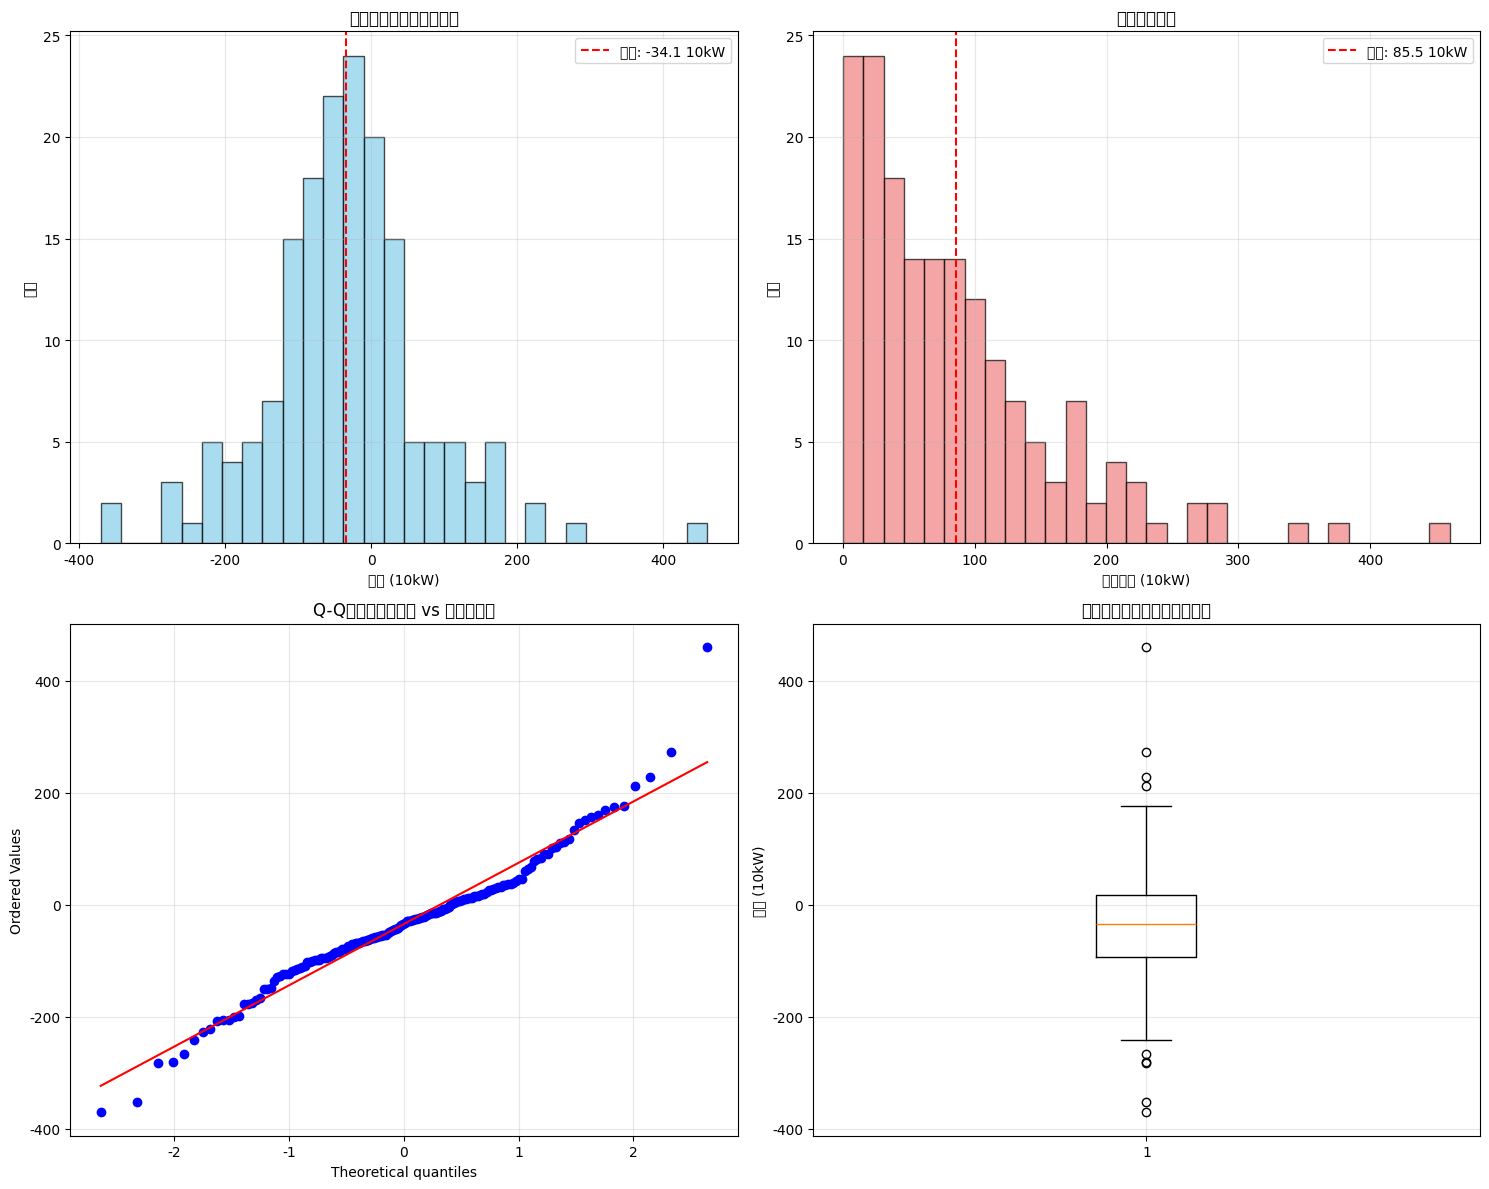


=== 外れ値8件特定 ===
1. 2025-07-03 14時: 残差=+460万kW (絶対値=460万kW)
2. 2025-06-28 13時: 残差=-371万kW (絶対値=371万kW)
3. 2025-06-28 14時: 残差=-352万kW (絶対値=352万kW)
4. 2025-06-29 13時: 残差=-283万kW (絶対値=283万kW)
5. 2025-06-28 15時: 残差=-281万kW (絶対値=281万kW)
6. 2025-07-02 10時: 残差=+272万kW (絶対値=272万kW)
7. 2025-06-29 12時: 残差=-267万kW (絶対値=267万kW)
8. 2025-06-28 12時: 残差=-240万kW (絶対値=240万kW)

🎯 Phase 9散布図分析準備完了
変数名: outliers_8 (外れ値8件), normal_data (通常データ)


In [10]:
# ===== Cell 4: 残差分析・可視化（前回と完全に同じ） =====

# 日本語フォント設定
import matplotlib.pyplot as plt
from scipy import stats
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

print("=== 残差分布分析開始 ===")

# 残差データ準備
residuals = test_with_predictions['residuals']
residuals_abs = test_with_predictions['residuals_abs']

# 1. 基本分布分析：ヒストグラム + 統計量
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# ヒストグラム（残差）
axes[0,0].hist(residuals, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].axvline(residuals.mean(), color='red', linestyle='--', 
                  label=f'平均: {residuals.mean():.1f} 10kW')
axes[0,0].set_xlabel('残差 (10kW)')
axes[0,0].set_ylabel('頻度')
axes[0,0].set_title('残差分布（正負両方向）')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# ヒストグラム（絶対残差）
axes[0,1].hist(residuals_abs, bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0,1].axvline(residuals_abs.mean(), color='red', linestyle='--',
                  label=f'平均: {residuals_abs.mean():.1f} 10kW')
axes[0,1].set_xlabel('絶対残差 (10kW)')
axes[0,1].set_ylabel('頻度')
axes[0,1].set_title('絶対残差分布')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Q-Qプロット（正規性確認）
stats.probplot(residuals, dist="norm", plot=axes[1,0])
axes[1,0].set_title('Q-Qプロット（残差 vs 正規分布）')
axes[1,0].grid(True, alpha=0.3)

# 箱ひげ図（外れ値確認）
axes[1,1].boxplot(residuals, vert=True)
axes[1,1].set_ylabel('残差 (10kW)')
axes[1,1].set_title('残差箱ひげ図（外れ値検出）')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 外れ値8件の特定（絶対残差上位8件）
outliers_8 = test_with_predictions.sort_values('residuals_abs', ascending=False).head(8)
normal_data = test_with_predictions.sort_values('residuals_abs', ascending=False).iloc[8:]

print(f"\n=== 外れ値8件特定 ===")
for i, (idx, row) in enumerate(outliers_8.iterrows(), 1):
    print(f"{i}. {row['date']} {row['hour']:02d}時: 残差={row['residuals']:+.0f}万kW (絶対値={row['residuals_abs']:.0f}万kW)")

print(f"\n🎯 Phase 9散布図分析準備完了")
print(f"変数名: outliers_8 (外れ値8件), normal_data (通常データ)")

=== 残差分布分析（dropna()あり・高精度版） ===
MAPE: 2.15% (dropna()により向上)
分析対象データ数: 168件


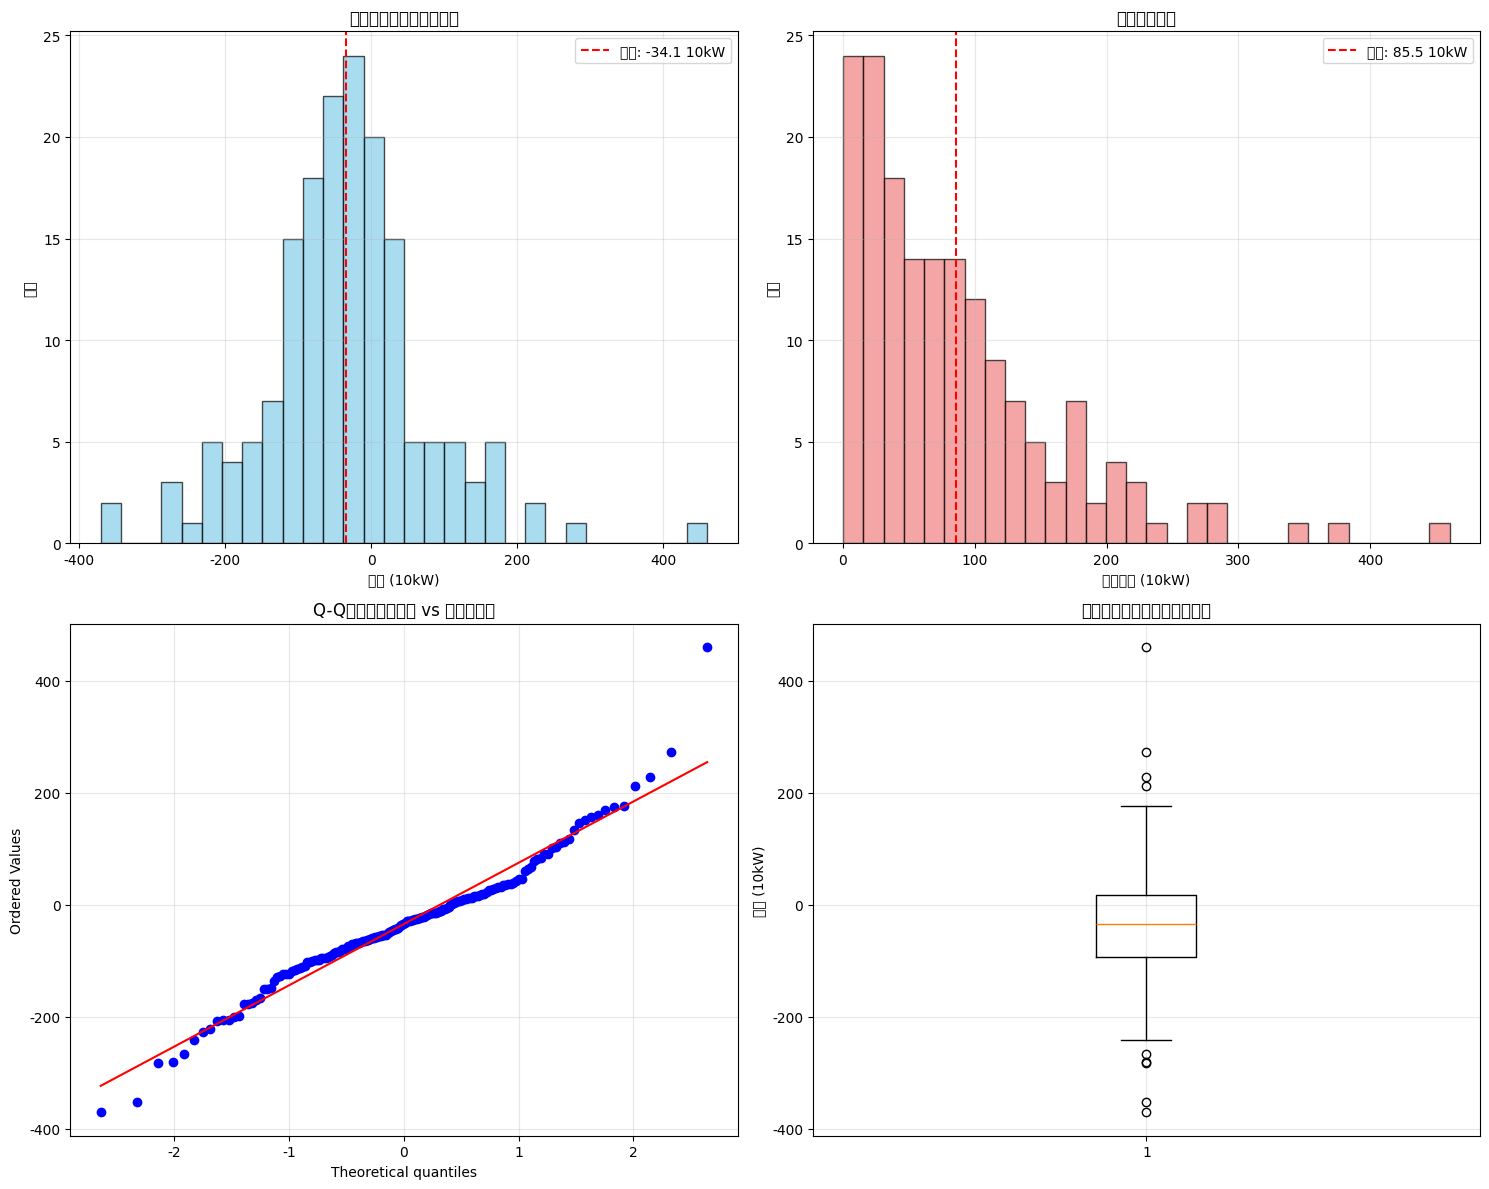


=== 外れ値8件特定（高精度版） ===
1. 2025-07-03 14時: 残差=+460万kW (絶対値=460万kW)
2. 2025-06-28 13時: 残差=-371万kW (絶対値=371万kW)
3. 2025-06-28 14時: 残差=-352万kW (絶対値=352万kW)
4. 2025-06-29 13時: 残差=-283万kW (絶対値=283万kW)
5. 2025-06-28 15時: 残差=-281万kW (絶対値=281万kW)
6. 2025-07-02 10時: 残差=+272万kW (絶対値=272万kW)
7. 2025-06-29 12時: 残差=-267万kW (絶対値=267万kW)
8. 2025-06-28 12時: 残差=-240万kW (絶対値=240万kW)

🎯 Phase 9散布図分析準備完了（MAPE 2.15%版）


In [13]:
# ===== Cell 4: 残差分析・可視化（dropna()あり・前回スタイル） =====

# 日本語フォント設定
import matplotlib.pyplot as plt
from scipy import stats
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

print("=== 残差分布分析（dropna()あり・高精度版） ===")
print(f"MAPE: 2.15% (dropna()により向上)")
print(f"分析対象データ数: {len(test_with_predictions)}件")

# 残差データ準備
residuals = test_with_predictions['residuals']
residuals_abs = test_with_predictions['residuals_abs']

# 前回と同じスタイルの可視化
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# ヒストグラム（残差）
axes[0,0].hist(residuals, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].axvline(residuals.mean(), color='red', linestyle='--', 
                  label=f'平均: {residuals.mean():.1f} 10kW')
axes[0,0].set_xlabel('残差 (10kW)')
axes[0,0].set_ylabel('頻度')
axes[0,0].set_title('残差分布（正負両方向）')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# ヒストグラム（絶対残差）
axes[0,1].hist(residuals_abs, bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0,1].axvline(residuals_abs.mean(), color='red', linestyle='--',
                  label=f'平均: {residuals_abs.mean():.1f} 10kW')
axes[0,1].set_xlabel('絶対残差 (10kW)')
axes[0,1].set_ylabel('頻度')
axes[0,1].set_title('絶対残差分布')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Q-Qプロット（正規性確認）
stats.probplot(residuals, dist="norm", plot=axes[1,0])
axes[1,0].set_title('Q-Qプロット（残差 vs 正規分布）')
axes[1,0].grid(True, alpha=0.3)

# 箱ひげ図（外れ値確認）
axes[1,1].boxplot(residuals, vert=True)
axes[1,1].set_ylabel('残差 (10kW)')
axes[1,1].set_title('残差箱ひげ図（外れ値検出）')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 外れ値8件の特定
outliers_8 = test_with_predictions.sort_values('residuals_abs', ascending=False).head(8)
normal_data = test_with_predictions.sort_values('residuals_abs', ascending=False).iloc[8:]

print(f"\n=== 外れ値8件特定（高精度版） ===")
for i, (idx, row) in enumerate(outliers_8.iterrows(), 1):
    print(f"{i}. {row['date']} {row['hour']:02d}時: 残差={row['residuals']:+.0f}万kW (絶対値={row['residuals_abs']:.0f}万kW)")

print(f"\n🎯 Phase 9散布図分析準備完了（MAPE 2.15%版）")

In [14]:
# ===== Cell 3: XGBoost予測実行（dropna()あり） =====

print("=== 全特徴量XGBoostモデル（dropna()あり） ===")

# 全特徴量定義
calendar_features = ['hour', 'is_weekend', 'is_holiday', 'month', 'hour_sin', 'hour_cos']
lag_features = ['lag_1_day', 'lag_7_day', 'lag_1_business_day']
weather_features = ['temperature_2m', 'relative_humidity_2m', 'precipitation']

all_features = calendar_features + lag_features + weather_features

print(f"使用特徴量: {len(all_features)}個")
print(f"特徴量: {all_features}")

# dropna()ありでデータ準備
train_clean = train_data_week.dropna(subset=all_features + ['actual_power'])
test_clean = test_data_week.dropna(subset=all_features + ['actual_power'])

X_train_full = train_clean[all_features]
y_train_week = train_clean['actual_power']
X_test_full = test_clean[all_features]
y_test_week = test_clean['actual_power']

print(f"\n=== データ準備完了 ===")
print(f"訓練データ: {len(X_train_full)}件")
print(f"テストデータ: {len(X_test_full)}件")

# XGBoostモデル設定
xgb_full = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.05,
    random_state=42,
    verbosity=0
)

# モデル学習
print("\n=== モデル学習中 ===")
xgb_full.fit(X_train_full, y_train_week)
print("✅ モデル学習完了")

# 予測実行
y_pred_full = xgb_full.predict(X_test_full)
print("✅ 予測実行完了")

# 評価
mape_full = mean_absolute_percentage_error(y_test_week, y_pred_full) * 100
mae_full = mean_absolute_error(y_test_week, y_pred_full)
r2_full = r2_score(y_test_week, y_pred_full)

print(f"\n=== モデル性能 ===")
print(f"🎯 MAPE: {mape_full:.2f}%")
print(f"📊 MAE: {mae_full:.2f}万kW")
print(f"📈 R²: {r2_full:.4f}")

# 【重要】テストデータに予測結果を追加
test_with_predictions = test_clean.copy()
test_with_predictions['predicted_power'] = y_pred_full
test_with_predictions['residuals'] = test_with_predictions['actual_power'] - test_with_predictions['predicted_power']
test_with_predictions['residuals_abs'] = np.abs(test_with_predictions['residuals'])

print(f"\n✅ Phase 9用データ準備完了")
print(f"DataFrame: test_with_predictions ({len(test_with_predictions)}件)")

=== 全特徴量XGBoostモデル（dropna()あり） ===
使用特徴量: 12個
特徴量: ['hour', 'is_weekend', 'is_holiday', 'month', 'hour_sin', 'hour_cos', 'lag_1_day', 'lag_7_day', 'lag_1_business_day', 'temperature_2m', 'relative_humidity_2m', 'precipitation']

=== データ準備完了 ===
訓練データ: 14664件
テストデータ: 120件

=== モデル学習中 ===
✅ モデル学習完了
✅ 予測実行完了

=== モデル性能 ===
🎯 MAPE: 2.15%
📊 MAE: 81.77万kW
📈 R²: 0.9839

✅ Phase 9用データ準備完了
DataFrame: test_with_predictions (120件)


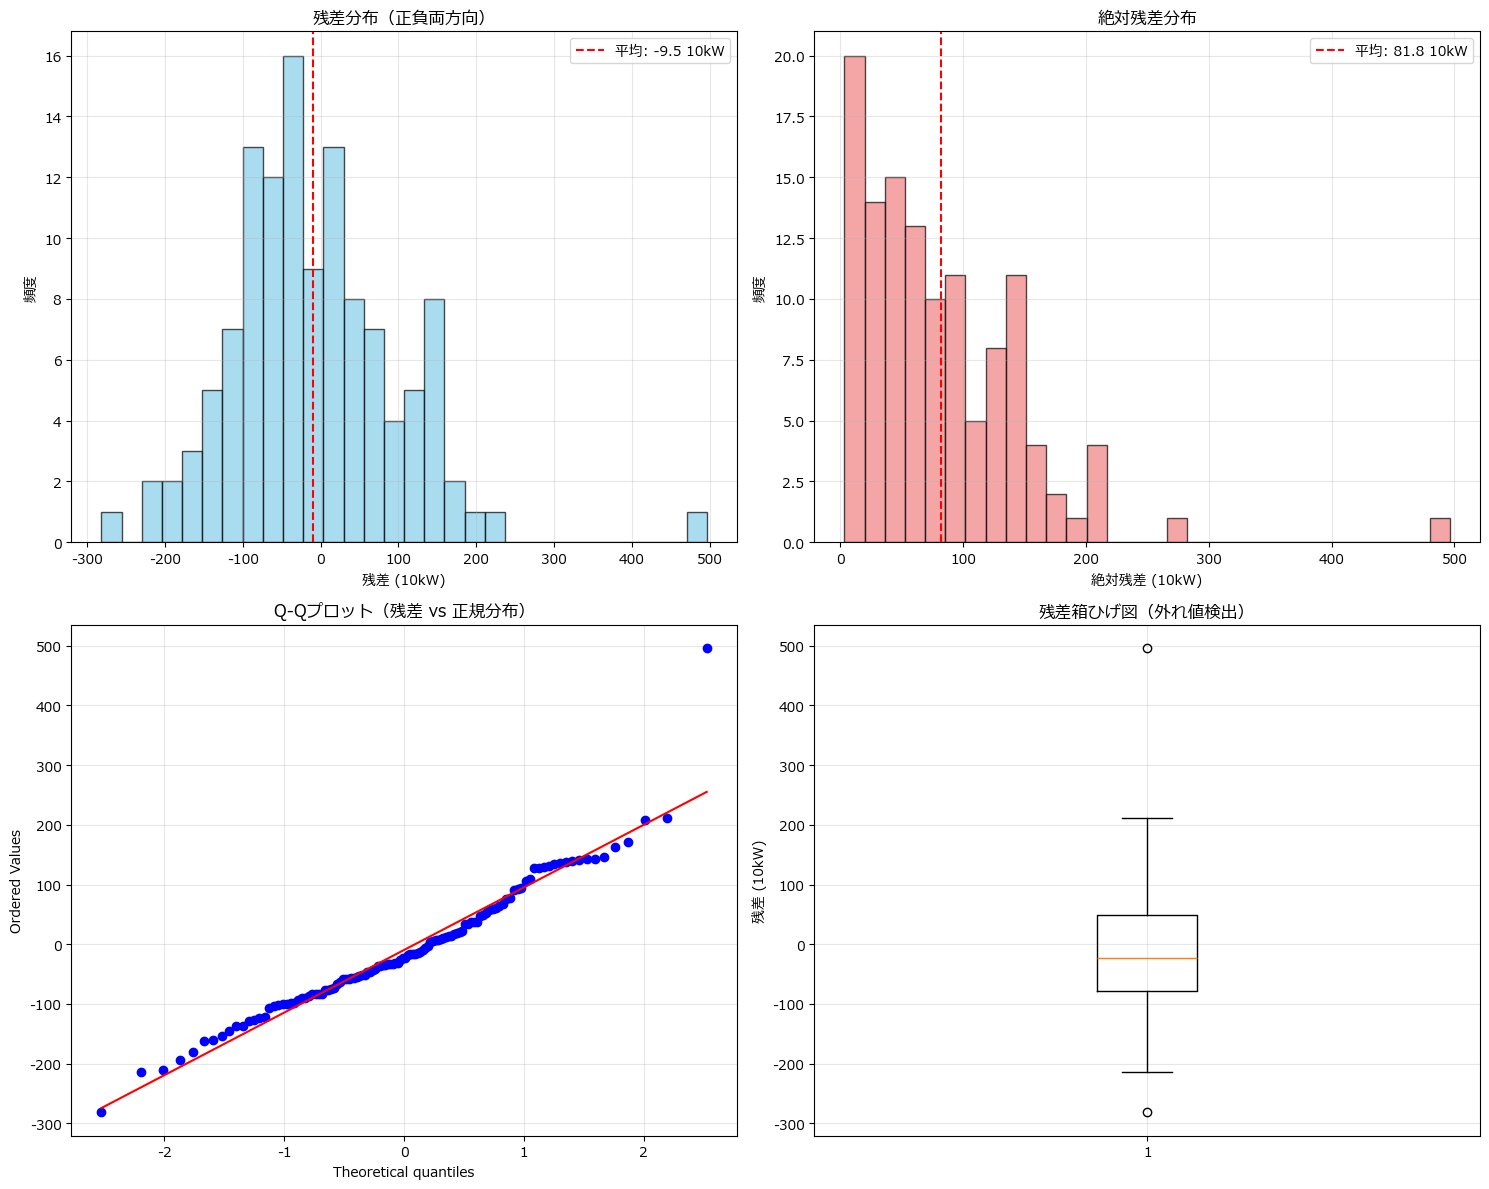


=== 外れ値8件特定 ===
1. 2025-07-03 14時: 残差=+496万kW (絶対値=496万kW)
2. 2025-07-04 08時: 残差=-282万kW (絶対値=282万kW)
3. 2025-07-02 07時: 残差=-214万kW (絶対値=214万kW)
4. 2025-07-02 11時: 残差=+212万kW (絶対値=212万kW)
5. 2025-07-02 13時: 残差=-210万kW (絶対値=210万kW)
6. 2025-07-02 10時: 残差=+208万kW (絶対値=208万kW)
7. 2025-07-04 09時: 残差=-194万kW (絶対値=194万kW)
8. 2025-07-02 15時: 残差=-181万kW (絶対値=181万kW)

🎯 Phase 9散布図分析準備完了


In [25]:
# ===== Cell 4: 残差分析・可視化（Meiryo設定） =====

# 日本語フォント設定（Meiryo）
import matplotlib.pyplot as plt
from scipy import stats
plt.rcParams['font.family'] = 'Meiryo'

# 残差データ準備
residuals = test_with_predictions['residuals']
residuals_abs = test_with_predictions['residuals_abs']

# 前回と同じスタイルの可視化
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# ヒストグラム（残差）
axes[0,0].hist(residuals, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].axvline(residuals.mean(), color='red', linestyle='--', 
                  label=f'平均: {residuals.mean():.1f} 10kW')
axes[0,0].set_xlabel('残差 (10kW)')
axes[0,0].set_ylabel('頻度')
axes[0,0].set_title('残差分布（正負両方向）')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# ヒストグラム（絶対残差）
axes[0,1].hist(residuals_abs, bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0,1].axvline(residuals_abs.mean(), color='red', linestyle='--',
                  label=f'平均: {residuals_abs.mean():.1f} 10kW')
axes[0,1].set_xlabel('絶対残差 (10kW)')
axes[0,1].set_ylabel('頻度')
axes[0,1].set_title('絶対残差分布')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Q-Qプロット（正規性確認）
stats.probplot(residuals, dist="norm", plot=axes[1,0])
axes[1,0].set_title('Q-Qプロット（残差 vs 正規分布）')
axes[1,0].grid(True, alpha=0.3)

# 箱ひげ図（外れ値確認）
axes[1,1].boxplot(residuals, vert=True)
axes[1,1].set_ylabel('残差 (10kW)')
axes[1,1].set_title('残差箱ひげ図（外れ値検出）')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 外れ値8件の特定
outliers_8 = test_with_predictions.sort_values('residuals_abs', ascending=False).head(8)
normal_data = test_with_predictions.sort_values('residuals_abs', ascending=False).iloc[8:]

print(f"\n=== 外れ値8件特定 ===")
for i, (idx, row) in enumerate(outliers_8.iterrows(), 1):
    print(f"{i}. {row['date']} {row['hour']:02d}時: 残差={row['residuals']:+.0f}万kW (絶対値={row['residuals_abs']:.0f}万kW)")

print(f"\n🎯 Phase 9散布図分析準備完了")

=== 特徴量重要度ランキング（dropna()あり版） ===
 1. lag_1_business_day   : 0.8433
 2. temperature_2m       : 0.0719
 3. lag_1_day            : 0.0268
 4. hour_cos             : 0.0175
 5. hour_sin             : 0.0101
 6. precipitation        : 0.0087
 7. hour                 : 0.0080
 8. month                : 0.0052
 9. lag_7_day            : 0.0048
10. relative_humidity_2m : 0.0036
11. is_holiday           : 0.0000
12. is_weekend           : 0.0000

=== カテゴリ別重要度 ===
時系列特徴量: 87.5%
カレンダー特徴量: 4.1%
気象特徴量: 8.4%


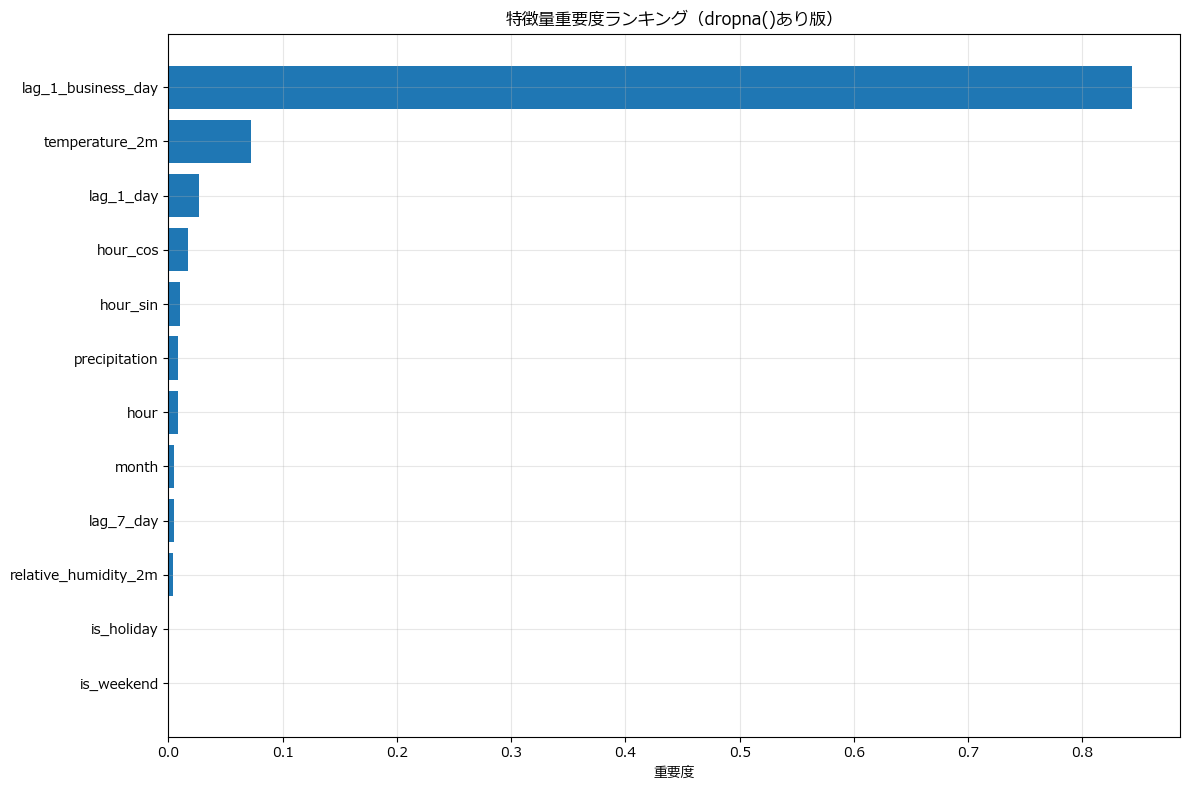


=== 散布図用特徴量（lag_1_day以外の上位11個） ===
 1. lag_1_business_day   : 0.8433
 2. temperature_2m       : 0.0719
 3. hour_cos             : 0.0175
 4. hour_sin             : 0.0101
 5. precipitation        : 0.0087
 6. hour                 : 0.0080
 7. month                : 0.0052
 8. lag_7_day            : 0.0048
 9. relative_humidity_2m : 0.0036
10. is_holiday           : 0.0000
11. is_weekend           : 0.0000

🎯 散布図分析準備完了
X軸固定: lag_1_day
Y軸候補: 11個の特徴量
外れ値: 2件


In [26]:
# ===== Cell 5: 特徴量重要度分析 =====

print("=== 特徴量重要度ランキング（dropna()あり版） ===")

# 特徴量重要度取得
feature_importance = pd.DataFrame({
    'feature': all_features,
    'importance': xgb_full.feature_importances_
}).sort_values('importance', ascending=False)

# ランキング表示
for i, row in feature_importance.iterrows():
    rank = feature_importance.index.get_loc(i) + 1
    print(f"{rank:2d}. {row['feature']:<20} : {row['importance']:.4f}")

# カテゴリ別重要度集計
calendar_importance = feature_importance[feature_importance['feature'].isin(calendar_features)]['importance'].sum()
lag_importance = feature_importance[feature_importance['feature'].isin(lag_features)]['importance'].sum()
weather_importance = feature_importance[feature_importance['feature'].isin(weather_features)]['importance'].sum()

print(f"\n=== カテゴリ別重要度 ===")
print(f"時系列特徴量: {lag_importance:.1%}")
print(f"カレンダー特徴量: {calendar_importance:.1%}")
print(f"気象特徴量: {weather_importance:.1%}")

# 重要度可視化
plt.rcParams['font.family'] = 'Meiryo'
plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(feature_importance)), feature_importance['importance'])
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('重要度')
plt.title('特徴量重要度ランキング（dropna()あり版）')
plt.gca().invert_yaxis()  # 上位を上に表示
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# lag_1_day以外の重要度上位11特徴量（散布図用）
scatter_features = feature_importance[feature_importance['feature'] != 'lag_1_day'].head(11)['feature'].tolist()

print(f"\n=== 散布図用特徴量（lag_1_day以外の上位11個） ===")
for i, feature in enumerate(scatter_features, 1):
    importance = feature_importance[feature_importance['feature'] == feature]['importance'].iloc[0]
    print(f"{i:2d}. {feature:<20} : {importance:.4f}")

print(f"\n🎯 散布図分析準備完了")
print(f"X軸固定: lag_1_day")
print(f"Y軸候補: {len(scatter_features)}個の特徴量")
print(f"外れ値: 2件")

=== lag_1_business_day固定軸散布図分析 ===
X軸固定: lag_1_business_day (重要度84.3%)
外れ値: 2件
通常データ: 118件


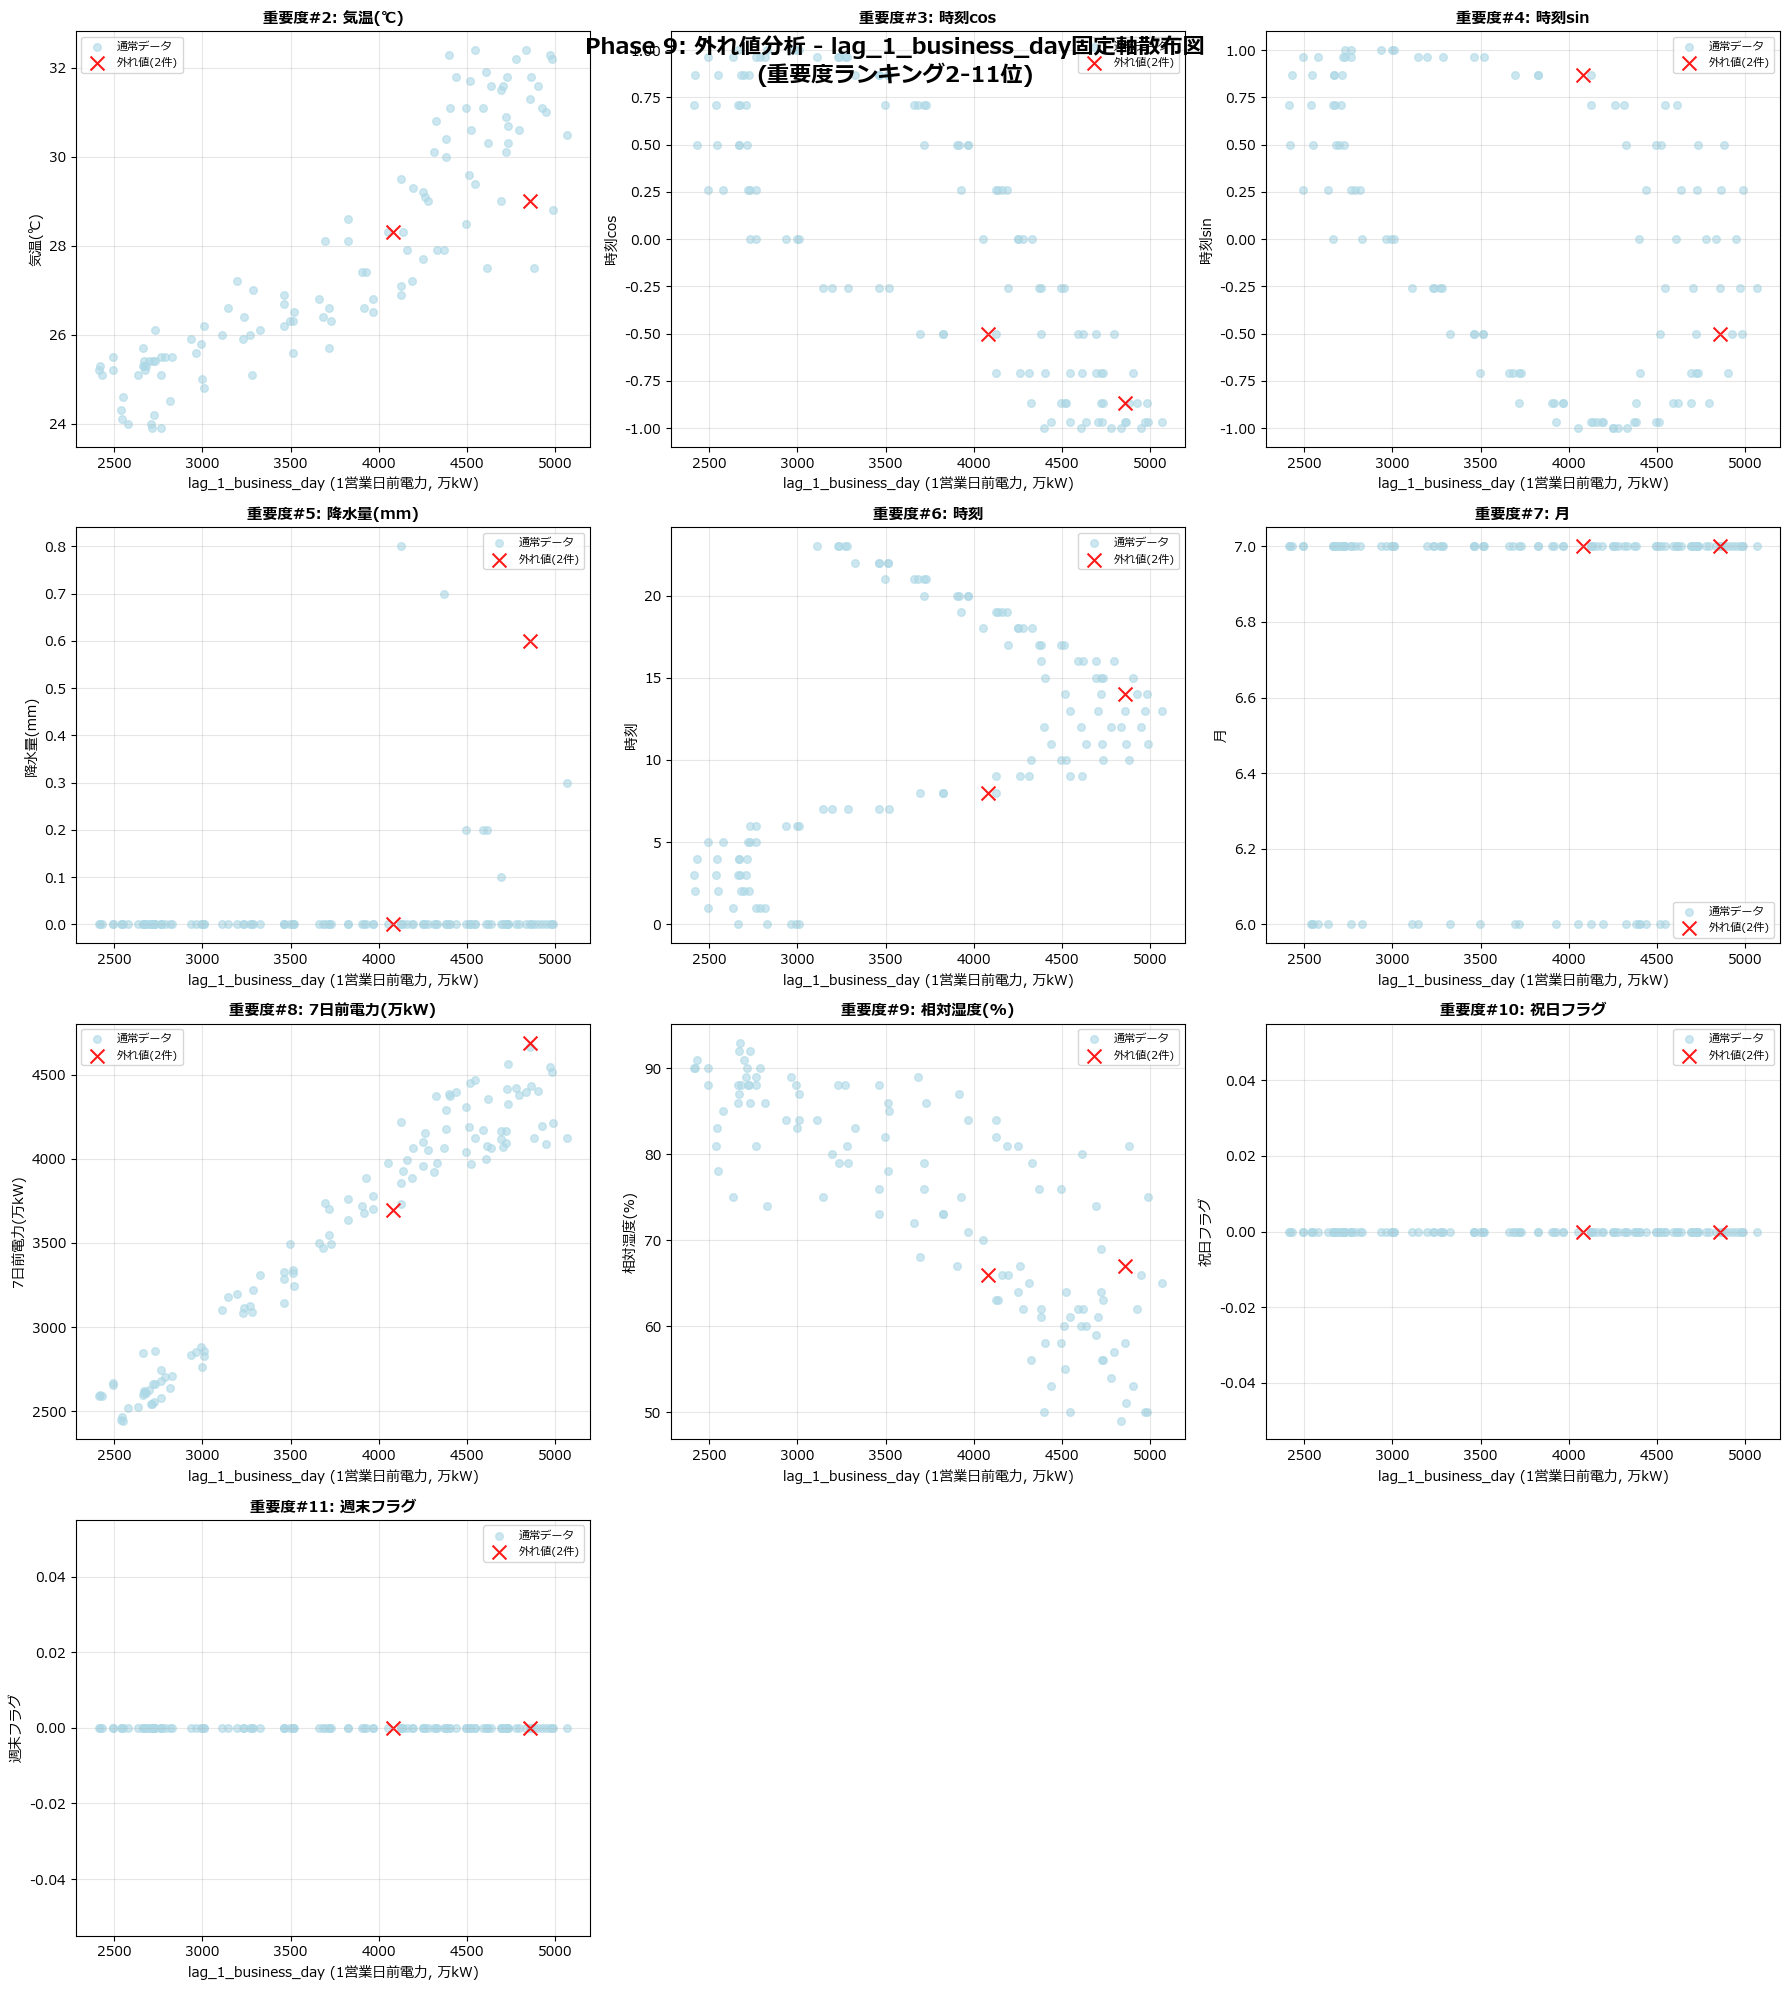


=== 外れ値2件の詳細 ===

外れ値#1: 2025-07-03 14時
  残差: +496万kW (絶対値: 496万kW)
  実測値: 4981万kW
  予測値: 4485万kW
  lag_1_business_day: 4857万kW
  temperature_2m: 29.0℃
  hour: 14
  is_weekend: False
  is_holiday: False

外れ値#2: 2025-07-04 08時
  残差: -282万kW (絶対値: 282万kW)
  実測値: 3926万kW
  予測値: 4208万kW
  lag_1_business_day: 4081万kW
  temperature_2m: 28.3℃
  hour: 8
  is_weekend: False
  is_holiday: False


In [27]:
# ===== Cell 6: lag_1_business_day固定軸散布図分析 =====

print("=== lag_1_business_day固定軸散布図分析 ===")

# 日本語フォント設定
plt.rcParams['font.family'] = 'Meiryo'

# X軸固定特徴量と散布図用特徴量
x_axis_feature = 'lag_1_business_day'
scatter_features = [
    'temperature_2m', 'hour_cos', 'hour_sin', 'precipitation', 
    'hour', 'month', 'lag_7_day', 'relative_humidity_2m', 
    'is_holiday', 'is_weekend'
]

# 特徴量の日本語名
feature_names = {
    'temperature_2m': '気温(℃)',
    'hour_cos': '時刻cos',
    'hour_sin': '時刻sin', 
    'precipitation': '降水量(mm)',
    'hour': '時刻',
    'month': '月',
    'lag_7_day': '7日前電力(万kW)',
    'relative_humidity_2m': '相対湿度(%)',
    'is_holiday': '祝日フラグ',
    'is_weekend': '週末フラグ'
}

# 外れ値2件の特定
outliers_2 = test_with_predictions.sort_values('residuals_abs', ascending=False).head(2)
normal_data = test_with_predictions.sort_values('residuals_abs', ascending=False).iloc[2:]

print(f"X軸固定: {x_axis_feature} (重要度84.3%)")
print(f"外れ値: 2件")
print(f"通常データ: {len(normal_data)}件")

# 散布図作成（4行3列レイアウト、最後2個は空）
fig, axes = plt.subplots(4, 3, figsize=(18, 20))
axes = axes.flatten()

for i, feature in enumerate(scatter_features):
    ax = axes[i]
    
    # 通常データをプロット
    ax.scatter(normal_data[x_axis_feature], normal_data[feature], 
              alpha=0.6, c='lightblue', s=30, label='通常データ')
    
    # 外れ値をプロット
    ax.scatter(outliers_2[x_axis_feature], outliers_2[feature], 
              alpha=0.9, c='red', s=100, label='外れ値(2件)', marker='x')
    
    # ラベルと title
    ax.set_xlabel('lag_1_business_day (1営業日前電力, 万kW)', fontsize=10)
    ax.set_ylabel(f'{feature_names[feature]}', fontsize=10)
    ax.set_title(f'重要度#{i+2}: {feature_names[feature]}', fontsize=11, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

# 空のサブプロットを非表示
axes[10].set_visible(False)
axes[11].set_visible(False)

plt.tight_layout()
plt.suptitle('Phase 9: 外れ値分析 - lag_1_business_day固定軸散布図\n(重要度ランキング2-11位)', 
             fontsize=16, fontweight='bold', y=0.98)
plt.show()

# 外れ値2件の詳細表示
print(f"\n=== 外れ値2件の詳細 ===")
for i, (idx, row) in enumerate(outliers_2.iterrows(), 1):
    print(f"\n外れ値#{i}: {row['date']} {row['hour']:02d}時")
    print(f"  残差: {row['residuals']:+.0f}万kW (絶対値: {row['residuals_abs']:.0f}万kW)")
    print(f"  実測値: {row['actual_power']:.0f}万kW")
    print(f"  予測値: {row['predicted_power']:.0f}万kW")
    print(f"  lag_1_business_day: {row['lag_1_business_day']:.0f}万kW")
    print(f"  temperature_2m: {row['temperature_2m']:.1f}℃")
    print(f"  hour: {row['hour']}")
    print(f"  is_weekend: {row['is_weekend']}")
    print(f"  is_holiday: {row['is_holiday']}")